<a href="https://colab.research.google.com/github/akshat-suwalka/NLP/blob/main/Transformer_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library

In [1]:
import torch 
import torch.nn as nn

#Model

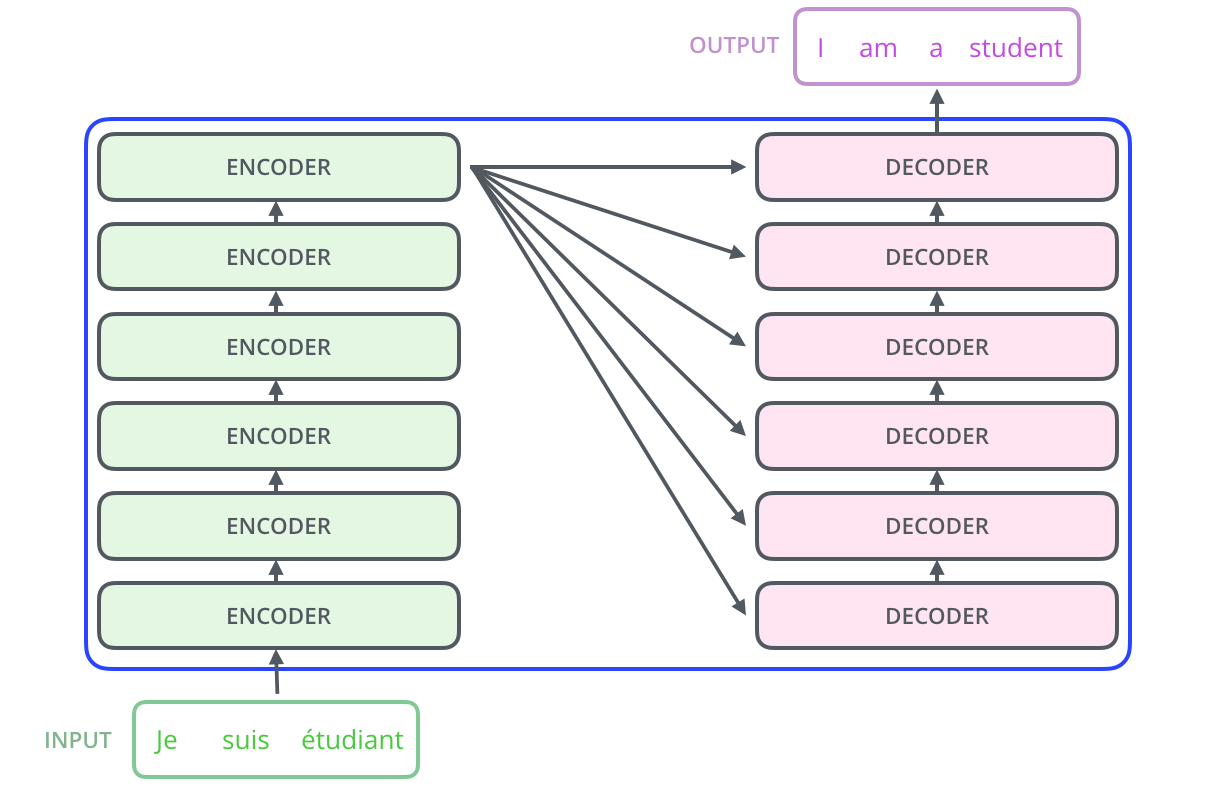

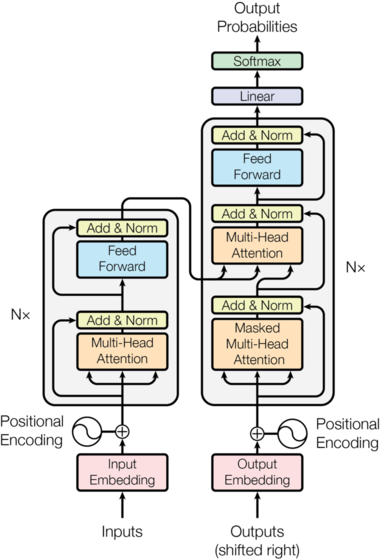

##Multi-Headed-Attention

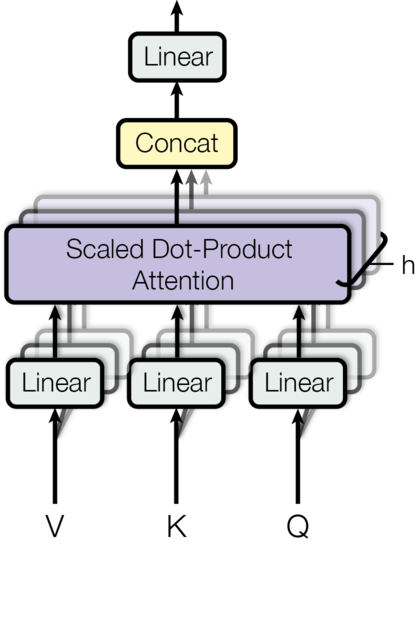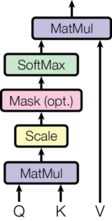

In [2]:
class Multi_Headed_Attention(nn.Module):
    def __init__(self, embed_size, heads):
        super(Multi_Headed_Attention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert(self.head_dim * self.heads == embed_size), "Head size is not appropriate, as the embed size should be divisible by head size"

        self.tovalues = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.tokeys = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.toqueries = nn.Linear(self.head_dim, self.head_dim, bias = False)

        self.unifyheads = nn.Linear(self.heads*self.head_dim, self.embed_size)

    def forward(self, value, key, query, mask):
        N = query.shape[0]
        values_len, keys_len, queries_len = value.shape[1], key.shape[1], query.shape[1]

        # Split embeddings into heads size or number of self attention head
        values = value.reshape(N, values_len, self.heads, self.head_dim)
        # values shape : (N, values_len, heads, head_dim) 
        keys = key.reshape(N, keys_len, self.heads, self.head_dim)
        # keys shape : (N, keys_len, heads, head_dim)
        queries = query.reshape(N, queries_len, self.heads, self.head_dim)
        # queries shape : (N, queries_len, heads, head_dim)

        # Now we have to pass values,keys,queries to neural network linear layer
        values = self.tovalues(values)
        keys = self.tokeys(keys)
        queries = self.toqueries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries,keys])
        # energy shape : (N, heads, queries_len, keys_len)

        if mask is not None:
            energy.masked_fill = (mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim = 3)
        # attention shape : (N, heads, query_len, keys_len)
        # softmax is applied along the keys for each query in a row

        out = torch.einsum("nhql,nlhv->nqhv", [attention,values]).reshape(N, queries_len, self.heads*self.head_dim)
        # attention * values
        # out shape before reshaping : (N, query_len, heads, head_dim)
        # out shape after reshaping : (N, query_len, heads * head_dim)

        out = self.unifyheads(out)
        return out
         

##Encoder Block

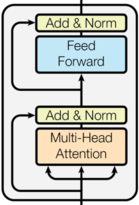

In [3]:
# For encoder --> the encoder block is exactly same as transformer block so no need to create separate Encoder Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = Multi_Headed_Attention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, embed_size*forward_expansion),
            nn.ReLU(),
            nn.Linear(embed_size*forward_expansion, embed_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, values, keys, queries, mask):
        attention = self.attention(values,keys,queries,mask)

        x = attention + queries    # Residual connection
        x = self.norm1(x)
        x = self.dropout(x)

        forward = self.feed_forward(x)

        out = x + forward          # Residual connection
        out = self.norm2(out)
        out = self.dropout(out)

        return out

##Encoder

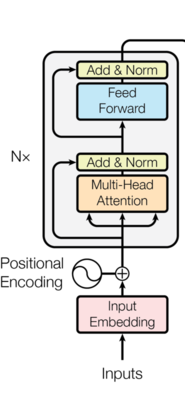

In [4]:
class Encoder(nn.Module):
    
    def __init__(
        self,
        src_vocab_size,           # hyperparameter
        embed_size,               # hyperparameter
        num_layers,                # hyperparameter
        heads,                    # hyperparameter
        device,
        forward_expansion,        # hyperparameter
        dropout,                  # hyperparameter
        max_length  # It means number of words in a sentence and also it is hyperparameter
    ):
        super(Encoder,self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [    # Note that Encoder block is exactly same as Transformer block
                TransformerBlock(embed_size, heads, dropout = dropout, forward_expansion = forward_expansion)
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x , mask):
      N, seq_len = x.shape
      # N : number of examples in a batch
      # seq_len : Number of words in a particular sentence/example

      position = torch.arange(0, seq_len)
      # position : single sentence 
      positions = position.expand(N, seq_len)
      # positions : all sentence 
      positions = positions.to(self.device)

      # combining word with their position
      out = self.word_embedding(x) + self.position_embedding(positions)
      out = self.dropout(out)

      for layer in self.layers:
        out = layer(out, out, out, mask)
      
      return out

##DecoderBlock

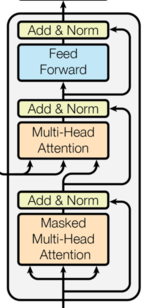

In [5]:
# To create decoder block, we have to add mask-multi-head-attention to transformer block and that's it !

class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.attention = Multi_Headed_Attention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)

        self.transformer_block = TransformerBlock(
            embed_size,
            heads,
            dropout = dropout,
            forward_expansion = forward_expansion
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, key, value, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        # Residual Connection
        x = attention + x
        x = self.norm(x)

        # query of decoder part
        query = self.dropout(x)

        # key, value --> comes from encoder part
        # query --> comes from decoder part
        out = self.transformer_block(value, key, query, src_mask)

        return out

## Decoder

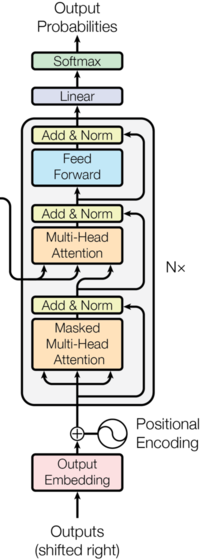

In [6]:
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length
    ): 
        super(Decoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embeddings = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
            for _ in range(num_layers)
            ]
        )

        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_len = x.shape
        positions = torch.arange(0,seq_len).expand(N, seq_len).to(self.device)

        x = self.word_embeddings(x) + self.position_embedding(positions)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(x)

        return out


## Complete Transformer

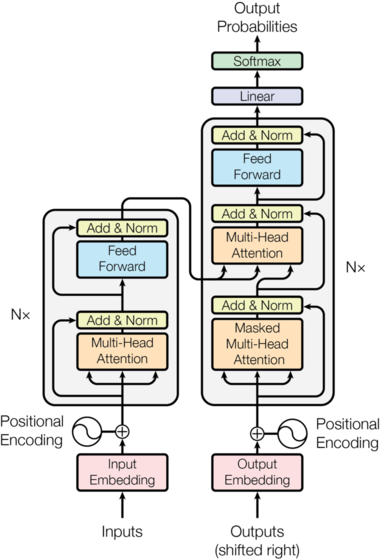

In [7]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size= 256,
        num_layers = 6,
        forward_expansion = 4,
        heads = 8,
        dropout = 0,
        device = "cuda",
        max_length = 100
    ):
        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N, 1, 1, src_len)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(N, 1, trg_len, trg_len)
        return trg_mask.to(self.device)

    def forward(self, src, targ):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out

#Example

In [8]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(
        device
    )
    trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]]).to(device)

    src_pad_idx = 0
    trg_pad_idx = 0
    src_vocab_size = 10
    trg_vocab_size = 10
    model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device).to(
        device
    )
    out = model(x, trg[:, :-1])
    print(out.shape)

cuda
torch.Size([2, 8, 10])
